In [1]:
!sudo pip install torchvision -q 
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

torch.cuda.set_device(1)

In [2]:
param = {'batch_size' : 64,
        'test_batch_size' : 1000,
        'lr' : 0.01,
        'momentum' : 0.5,
        'log_interval' : 1}

## DATA LOADER

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=param['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=param['test_batch_size'], shuffle=True)

torch.Size([28, 28])


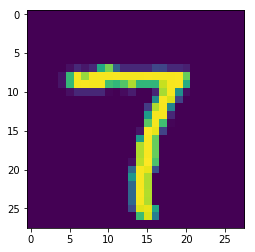

In [71]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    batch_idx
    break

print(data[0,0].shape)
plt.imshow(data[0,0].cpu().numpy())


torch.Size([28, 28])

## NEURAL NET

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = Net()
model.cuda()

Net (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (320 -> 50)
  (fc2): Linear (50 -> 10)
)

In [61]:
# To predict one digi:

# Cast into variable:
x = Variable(data[:1,])

model.forward(x)

RuntimeError: Variable data has to be a tensor, but got Variable

## Train

In [62]:
optimizer = optim.SGD(model.parameters(), lr=param['lr'], momentum=param['momentum'])

In [64]:
def train_epoch(epoch):
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = Variable(data.cuda()), Variable(target.cuda())

        optimizer.zero_grad()
        yhat = model(data)
        loss = F.nll_loss(yhat,target)
        loss.backward()
        optimizer.step()
        
    if epoch % param['log_interval'] == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))
        test()
        
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [65]:
for epoch in range(10):
    train_epoch(epoch)

Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.499056

Test set: Average loss: 0.2173, Accuracy: 9343/10000 (93%)

Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.436641

Test set: Average loss: 0.1233, Accuracy: 9625/10000 (96%)

Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.166448

Test set: Average loss: 0.0965, Accuracy: 9687/10000 (97%)

Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.490967

Test set: Average loss: 0.0827, Accuracy: 9735/10000 (97%)

Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.062045

Test set: Average loss: 0.0705, Accuracy: 9776/10000 (98%)

Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.391029

Test set: Average loss: 0.0665, Accuracy: 9789/10000 (98%)

Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.051859

Test set: Average loss: 0.0627, Accuracy: 9811/10000 (98%)

Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.152845

Test set: Average loss: 0.0587, Accuracy: 9815/10000 (98%)

Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.098821

Test set: Average loss: 0.0549, Accuracy: 9823/10000

In [27]:
data, target = test_loader.__iter__().next()

data, target = Variable(data.cuda()), Variable(target.cuda())

yhat = model(data)

In [47]:
pred_class = yhat.data.max(1)[1]
pred_class


 8
 3
 0
⋮ 
 0
 2
 6
[torch.cuda.LongTensor of size 1000 (GPU 1)]

10000

In [51]:
pred_class.eq(target.data.view_as(pred_class)).cpu().sum()

944